# Neural Network for MNIST database recognizing

This is a Neural Network developed without Machine Learning frameworks, using `numpy` and `matplotlib`, only for learning purposes. The objective of this project is practice Neural Networks Design principles and enhance knowledges on Machine Learning and Deep Learning.


## 1 - Library imports

Using `numpy`, `matplotlib`, `mnist` (Anaconda version), `os` and `enum`.

In [32]:
import numpy as np
np.seterr(all='warn')

import mnist
import matplotlib.pyplot as plt
import os
from enum import Enum, unique

## 2 - MNIST Datasets download

Datasets download made with `mnist` library.

In [33]:
if(not os.path.isdir("./datasets/")):
    os.mkdir("./datasets")
if(not os.path.isfile("./datasets/train-images-idx3-ubyte.gz")):
    mnist.download_file("train-images-idx3-ubyte.gz", "./datasets")
if(not os.path.isfile("./datasets/train-labels-idx1-ubyte.gz")):
    mnist.download_file("train-labels-idx1-ubyte.gz", "./datasets")
if(not os.path.isfile("./datasets/t10k-images-idx3-ubyte.gz")):
    mnist.download_file("t10k-images-idx3-ubyte.gz", "./datasets")
if(not os.path.isfile("./datasets/t10k-labels-idx1-ubyte.gz")):
    mnist.download_file("t10k-labels-idx1-ubyte.gz", "./datasets")

## 3 - MNIST Datasets Load

Load and reshaping of the datasets. Labels converted to one-hot encoding.

In [34]:
train_images_raw = mnist.train_images()
train_labels_raw = mnist.train_labels()
test_images_raw = mnist.test_images()
test_labels_raw = mnist.test_labels()

train_images = np.transpose(train_images_raw.reshape(train_images_raw.shape[0], train_images_raw.shape[1]*train_images_raw.shape[2]))

train_labels = np.zeros((train_labels_raw.shape[0], train_labels_raw.max()+1))
train_labels[np.arange(train_labels_raw.shape[0]), train_labels_raw] = 1
train_labels = np.transpose(train_labels)

test_images = np.transpose(test_images_raw.reshape(test_images_raw.shape[0], test_images_raw.shape[1]*test_images_raw.shape[2]))

test_labels = np.zeros((test_labels_raw.shape[0], test_labels_raw.max()+1))
test_labels[np.arange(test_labels_raw.shape[0]), test_labels_raw] = 1
test_labels = np.transpose(test_labels)

## 4 - Activation functions enum

Activation enum. It's used to select whether activation function will be applied on each layer.

In [35]:
@unique
class Activation(Enum):
    SIGMOID = 1
    TANH = 2
    RELU = 3
    LEAKY_RELU = 4

## 5 - Hyperparameters

Hyperparameter constants. It's adjusted and applied on functions.

In [36]:
FEATURES = train_images.shape[0]

LAYER_UNITS = np.array([32, 32, 16, 10], dtype=np.uint32)
LAYER_ACTIVATIONS = np.array([Activation['RELU'], Activation['RELU'], Activation['TANH'], Activation['SIGMOID']])
LAYERS = LAYER_UNITS.shape[0]
ALPHA = 10e-3
LAMBDA_REG = 10e-8
EPOCHS = 100
EPSILON = 10e-8
MINIBATCH_SIZE = 512
LEARNING_DECAY = 0.95
BETA_MOMENTUM = 0.9
BETA_RMS = 0.999

EXAMPLES = train_images.shape[1]

## 6 - Activation functions and it's derivatives

Linear function, Sigmoid, Tanh, ReLU and Leaky ReLU.

In [37]:
LEAKY_RELU_MULTIPLIER = 0.01

def linear_func(X_matrix, W_matrix, b_array):
    return np.dot(W_matrix, X_matrix) + b_array

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def sigmoid_threshold(z):
    return np.round(z)

def tanh(z):
    return np.tanh(z)

def relu(z):
    return np.maximum(0, z)

def leaky_relu(z):
    return np.maximum(LEAKY_RELU_MULTIPLIER * z, z)

def derivative_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

def derivative_tanh(z):
    return 1 - (tanh(z)**2)

def derivative_relu(z):
    if(z < 0):
        return 0
    else:
        return 1

def derivative_leaky_relu(z):
    if(z < 0):
        return LEAKY_RELU_MULTIPLIER
    else:
        return 1

derivative_relu = np.vectorize(derivative_relu)
derivative_leaky_relu = np.vectorize(derivative_leaky_relu)

## 7 - Normalization functions

For some reason, normalization with mean and standard was buggy, so... I just divided each feature by it's maximum.

In [38]:
def normalize_dataset(X_matrix):
    X_norm = np.zeros(X_matrix.shape)
    for i in range(X_matrix.shape[0]):
        X_norm[i] = X_matrix[i]/np.maximum(1, np.max(X_matrix[i]))
    return X_norm

def normalize_input(x_input, X_matrix):
    x_norm = np.zeros(x_input.shape)
    x_norm = x_input/np.maximum(1, np.max(X_matrix))
    return x_norm

## 8 - Forward and Backward Propagation Functions

Fwdprop and backprop functions (optimizations are done in fit function).

In [39]:
def fwd_prop(A_previous, W_layer, b_layer, activationType = Activation['SIGMOID']):
    Z_layer = linear_func(A_previous, W_layer, b_layer)
    if (activationType == Activation['SIGMOID']):
        A_layer = sigmoid(Z_layer)
    elif (activationType == Activation['TANH']):
        A_layer = tanh(Z_layer)
    elif (activationType == Activation['RELU']):
        A_layer = relu(Z_layer)
    elif (activationType == Activation['LEAKY_RELU']):
        A_layer = leaky_relu(Z_layer)
    else:
        A_layer = sigmoid(Z_layer)
    return A_layer, Z_layer

def back_prop(dA_layer, A_previous, Z_layer, W_layer, b_layer, activationType = Activation['SIGMOID']):
    if (activationType == Activation['SIGMOID']):
        dZ_layer = np.multiply(dA_layer, derivative_sigmoid(Z_layer))
    elif (activationType == Activation['TANH']):
        dZ_layer = np.multiply(dA_layer, derivative_tanh(Z_layer))
    elif (activationType == Activation['RELU']):
        dZ_layer = np.multiply(dA_layer, derivative_relu(Z_layer))
    elif (activationType == Activation['LEAKY_RELU']):
        dZ_layer = np.multiply(dA_layer, derivative_leaky_relu(Z_layer))
    else:
        dZ_layer = np.multiply(dA_layer, derivative_sigmoid(Z_layer))
    
    dW_layer = np.dot(dZ_layer, np.transpose(A_previous))/dZ_layer.shape[1]
    db_layer = np.sum(dZ_layer, axis = 1, keepdims = True)/dZ_layer.shape[1]
    dA_previous = np.dot(np.transpose(W_layer), dZ_layer)

    return dA_previous, dW_layer, db_layer   

## 9 - Predict Function

Prediction based on calculated weights and biases.

In [40]:
def predict(X, W, b,
            layers = LAYERS,
            layer_activations = LAYER_ACTIVATIONS):
    A = X
    for i in range(1, layers+1):
        A, z = fwd_prop(A, W[i], b[i], layer_activations[i-1])
    return A

## 10 - Cost function

For some reason, $- y \cdot \text{log}(y_{prediction}) - (1 - y) \cdot \text{log}(1 - y_{prediction})$ didn't work so well, so I used mean squared error instead.

This cost function doesn't affect neither the propagation functions, nor the fit function. 

In [41]:
def cost(X, y, W, b, lambda_reg = LAMBDA_REG):
    y_prediction = predict(X, W, b)
    regularization = 0
    loss = (1/2)*((y_prediction - y)**2)
    for i in W:
        regularization += np.sum(i**2)
    cost = (np.sum(loss, axis = 1, keepdims=True)/y.shape[1]) + ((lambda_reg/(2*y.shape[1]))*regularization)
    return cost

## 11 - Fit Function

Fit function is implemented with optimization. (I'm using Adam)

In [42]:
def fit(X, y,
        W_previous = None,
        b_previous = None,
        features = FEATURES,
        layers = LAYERS,
        layer_units = LAYER_UNITS,
        layer_activations = LAYER_ACTIVATIONS,
        examples = EXAMPLES,
        alpha = ALPHA,
        learning_decay = LEARNING_DECAY,
        lambda_reg = LAMBDA_REG,
        epochs = EPOCHS,
        epsilon = EPSILON,
        mb_size = MINIBATCH_SIZE,
        beta_momentum = BETA_MOMENTUM,
        beta_rms = BETA_RMS):
    
    W = {1: np.random.randn(layer_units[0], features) * np.sqrt(2/features)}
    dW = {1: np.zeros([layer_units[0], features])}
    b = {1:np.random.randn(layer_units[0], 1)}
    db = {1: np.zeros([layer_units[0], 1])}
    Z = {0: X}
    A = {0: X}
    dA = {0: np.array([])}
    for k in range(layers - 1):
        W[k+2] = np.random.randn(layer_units[k+1], layer_units[k]) * np.sqrt(1/layer_units[k])
        dW[k+2] = np.zeros([layer_units[k+1], layer_units[k]])
        b[k+2] = np.random.randn(layer_units[k+1], 1)
        db[k+2] = np.zeros([layer_units[k+1], 1])
        Z[k+1] = np.zeros([layer_units[k+1], examples])
        A[k+1] = np.zeros([layer_units[k+1], examples])
        dA[k+1] = np.zeros([layer_units[k+1], examples])

    if(W_previous != None and b_previous != None):
        W = W_previous
        b = b_previous

    alpha_decay = alpha

    cost_points = []

    for i in range(epochs):

        vdW = {}
        vdb = {}
        sdW = {}
        sdb = {}
        for v in range(1, layers+1):
            vdW[v] = np.zeros(dW[v].shape)
            vdb[v] = np.zeros(db[v].shape)
            sdW[v] = np.zeros(dW[v].shape)
            sdb[v] = np.zeros(db[v].shape)

        print(f"\rEpoch {i+1} of {epochs}", end="")

        for k in range(int(np.ceil(A[0].shape[1]/mb_size))):

            mb_start = k*mb_size
            mb_end = np.minimum((k+1)*mb_size, A[0].shape[1])

            for j in range(layers):
                if(j == 0):
                    A[j+1], Z[j+1] = fwd_prop(A[j][:, mb_start:mb_end], W[j+1], b[j+1], layer_activations[j])
                else:
                    A[j+1], Z[j+1] = fwd_prop(A[j], W[j+1], b[j+1], layer_activations[j])

            dA[layers] = - (y[:, mb_start:mb_end]/A[layers]) + ((1-y[:, mb_start:mb_end])/(1-A[layers]))

            for j in range(layers-1, -1, -1):
                if(j == 0):
                    dA[j], dW[j+1], db[j+1] = back_prop(dA[j+1], A[j][:, mb_start:mb_end], Z[j+1], W[j+1], b[j+1], layer_activations[j])
                else:
                    dA[j], dW[j+1], db[j+1] = back_prop(dA[j+1], A[j], Z[j+1], W[j+1], b[j+1], layer_activations[j])
            
            for j in range(1, layers+1):
                vdW[v] = ((beta_momentum * vdW[v]) + ((1 - beta_momentum) * dW[v]))/(1 + (beta_momentum**(k+1)))
                vdb[v] = ((beta_momentum * vdb[v]) + ((1 - beta_momentum) * db[v]))/(1 + (beta_momentum**(k+1)))
                sdW[v] = ((beta_rms * sdW[v]) + ((1 - beta_rms) * dW[v]**2))/(1 + (beta_rms**(k+1)))
                sdb[v] = ((beta_rms * sdb[v]) + ((1 - beta_rms) * db[v]**2))/(1 + (beta_rms**(k+1)))
                W[j] = (W[j] * (1 - ((alpha_decay*lambda_reg)/y.shape[1]))) - (alpha_decay*(vdW[j]/(epsilon + np.sqrt(sdW[j]))))
                b[j] = b[j] - (alpha_decay*(vdb[j]/(epsilon + np.sqrt(sdb[j]))))
    
            cost_points.append(cost(X[:, mb_start:mb_end], y[:, mb_start:mb_end], W, b))
        
        alpha_decay = alpha*(learning_decay**(i+1))

        #print(np.transpose(cost_points[len(cost_points) - 1]))
    
    print("\r                        ", end="")
    print("\rDone.")

    return W, b

## 12 - Training the N.N.

Running fit function

In [43]:
train_images_normalized = normalize_dataset(train_images)
W_final, b_final = fit(train_images_normalized, train_labels)

Done.                   


## 13 - Saving Checkpoint

Here we can save the results of fitting. We can run a new fit not losing previous fit in `W_save` and `b_save`.

In [44]:
W_save = W_final
b_save = b_final

If `ACTIVE_SAVING_CHECKPOINT` == `True`, `W_save` and `b_save` are saved on `.csv` files.

In [45]:
ACTIVE_SAVING_CHECKPOINT = False

if(ACTIVE_SAVING_CHECKPOINT):
    if(not os.path.isdir("./training-checkpoint/")):
        os.mkdir("./training-checkpoint/")

    for i in W_save:
        np.savetxt(f'./training-checkpoint/w{i}.csv', W_save[i], delimiter=',')
    for i in b_save:
        np.savetxt(f'./training-checkpoint/b{i}.csv', b_save[i], delimiter=',')

## 14 - Loading Checkpoint

If `ACTIVE_LOADING_CHECKPOINT` == `True`, `W_save` and `b_save` are loaded with `.csv` files content.

In [46]:
ACTIVE_LOADING_CHECKPOINT = False

if(ACTIVE_LOADING_CHECKPOINT):
    W_save = {}
    b_save = {}
    for i in range(1, LAYERS + 1):
        W_save[i] = np.loadtxt(f'./training-checkpoint/w{i}.csv', delimiter=',')
        b_save[i] = np.loadtxt(f'./training-checkpoint/b{i}.csv', delimiter=',')
        b_save[i] = np.reshape(b_save[i], (b_save[i].shape[0], 1))

## 15 - Measuring accuracy on test set

In [47]:
test_images_normalized = normalize_input(test_images, train_images)
test_outputs = np.transpose(sigmoid_threshold(np.transpose(predict(test_images_normalized, W_save, b_save))))
test_comparison = np.array([np.array_equal(test_outputs[:, i], test_labels[:, i]) for i in range(test_outputs.shape[1])])
test_accuracy = np.sum(test_comparison)*100/test_comparison.shape[0]
print(f"Accuracy on test set prediction: {test_accuracy} %")

Accuracy on test set prediction: 14.87 %


## 16 - Measuring accuracy on train set

In [48]:
train_images_normalized = normalize_dataset(train_images)
train_outputs = np.transpose(sigmoid_threshold(np.transpose(predict(train_images_normalized, W_save, b_save))))
train_comparison = np.array([np.array_equal(train_outputs[:, i], train_labels[:, i]) for i in range(train_outputs.shape[1])])
train_accuracy = np.sum(train_comparison)*100/train_comparison.shape[0]
print(f"Accuracy on train set prediction: {train_accuracy} %")

Accuracy on train set prediction: 14.17 %


## 17 - Test playground

Saída esperada: 2
Sem predição válida.


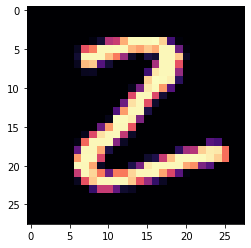

In [49]:
index = int(np.round(np.random.rand()*len(test_images_raw)))

plt.imshow(test_images_raw[index], cmap='magma')
test_sample = normalize_input(test_images[:, index].reshape(test_images[:, index].shape[0], 1), train_images)
test_predict = sigmoid_threshold(np.transpose(predict(test_sample, W_save, b_save)))
print(f"Saída esperada: {test_labels_raw[index]}")
for i in range(len(test_predict[0])):
    if test_predict[0, i] == 1:
        print(f"Saída predita: {i}")
        break
    if(i == 9):
        print(f"Sem predição válida.")